In [2]:
#control parameter fitting
import scipy.optimize
import scipy.signal
import numpy as np

import matplotlib.pyplot as plt
import pandas

import control.matlab as control

#MOTOR EMPIRCAL PARAMS

#voltage supply
PWM_AMPLITUDE = 12
DC_STEPS = [128, 256, 512, 1024]

#second order model
def so_model(x,K,wn,zeta):
    tf = control.tf([K],[1,2*wn*zeta,wn**2])
    yout,T = control.step(tf, T=x)
    return yout[-1]

import asyncio
import time
from serial_interface.serial_interface import TwidSerialInterfaceProtocol, TelemetryFrame, run_test, ControlType, start_protocol, TwidID

import os

###SERIAL CONFIGURATION for esp32
SERIAL_PORT = 'COM4'
SERIAL_BAUD_RATE = 1000000

DATA_DIR_PATH = os.path.join(os.getcwd(),'data')

In [2]:
twid = await start_protocol(asyncio.get_event_loop(), SERIAL_PORT, SERIAL_BAUD_RATE)
tid = TwidID.TWID1_ID

for step_input in DC_STEPS:
    await twid.update_telem_sample_rate(tid, 5)
    await asyncio.sleep(1)
    await twid.update_control_type(tid, ControlType.NO_CTRL)
    await twid.update_dutycycle(twid_id=tid, duty_cycle=step_input)
    df = await twid.collect_telem(twid_id=tid, duration=5, collect_old_buffer= True)
    await twid.motor_stop()
    df.to_csv(os.path.join(DATA_DIR_PATH,f'{time.strftime('%Y-%m-%d_%H-%M')}_current_step_response_{step_input}.csv'), index=False)
    await asyncio.sleep(0.5)
await twid.end()

Text(0, 0.5, 'rpm')

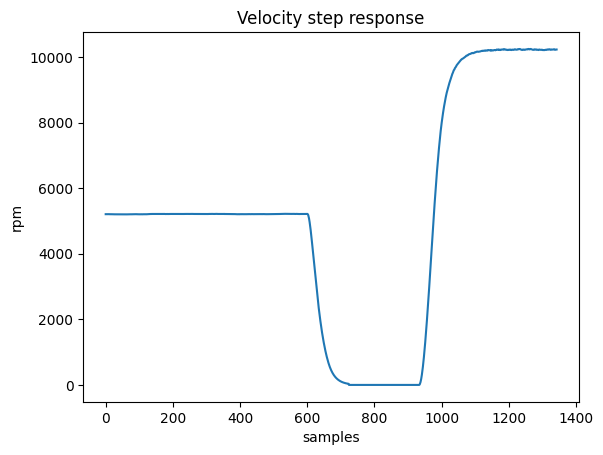

In [3]:
plt.plot(df["filtered_velocity"])
plt.title("Velocity step response")
plt.xlabel('samples')
plt.ylabel('rpm')

Text(0, 0.5, 'Amps')

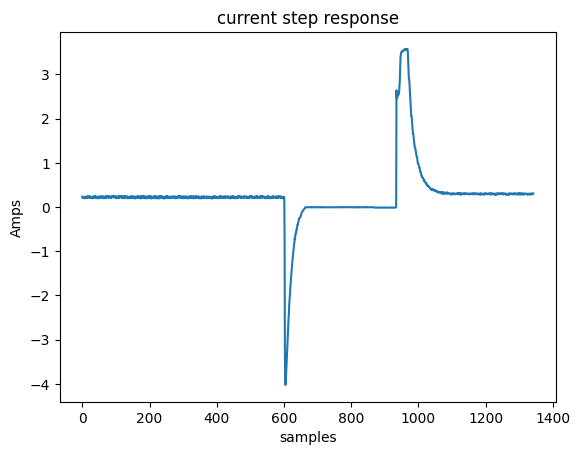

In [6]:
plt.plot(df["current"])
plt.title("current step response")
plt.xlabel('samples')
plt.ylabel('Amps')

In [28]:
twid = await start_protocol(asyncio.get_event_loop(), SERIAL_PORT, SERIAL_BAUD_RATE)
tid = TwidID.TWID1_ID

await twid.update_impedance(tid, K = 0, B = 10, J = 0)
await twid.update_pid(tid,2.0,0.1,0.05)
await twid.update_setpoint(tid, position=0, velocity=1000)
await twid.update_control_type(tid, ControlType.VELOCITY_CTRL)
await asyncio.sleep(5)
await twid.end()

SerialException: could not open port 'COM4': PermissionError(13, 'Access is denied.', None, 5)

In [13]:
step_input = 128
#save as a nice csv using pandas
df.to_csv(os.path.join(DATA_DIR_PATH,f'current_step_response_{step_input}.csv'), index=False)

#collect info from start of step only
ts = df['timestamp_ms'][df['pwm_duty_cycle'] >= step_input]
print(ts)
current = df['filtered_current'][df['pwm_duty_cycle'] >= step_input]
vel = df['filtered_velocity'][df['pwm_duty_cycle'] >= step_input]

#apply curve fitting to get second order params using scipy
[K, wn, zeta],_ = scipy.optimize.curve_fit(so_model, ts.to_numpy(), current.to_numpy())
output_str = f'Step response estimated second order parameters:\n\
    K:{K}\twn:{wn}\tzeta:{zeta}\n'
print(output_str)

[K, wn, zeta],_ = scipy.optimize.curve_fit(so_model, ts.to_numpy(), vel.to_numpy())
output_str = f'Step response estimated second order parameters:\n\
    K:{K}\twn:{wn}\tzeta:{zeta}\n'
print(output_str)

212    46873.0
213    46878.0
214    46883.0
215    46888.0
216    46893.0
        ...   
628    48953.0
629    48958.0
630    48963.0
631    48968.0
632    48973.0
Name: timestamp_ms, Length: 421, dtype: float64


c:\Users\you29\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1117: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\you29\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1117: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\you29\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1119: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U
c:\Users\you29\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:380: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
c:\Users\you29\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:380: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Step response estimated second order parameters:
    K:208.3848935556778	wn:30.768075384907338	zeta:94.36276126044706



c:\Users\you29\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1119: RuntimeWarning: overflow encountered in matmul
  yout = C @ xout + D @ U


Step response estimated second order parameters:
    K:20.943400961691218	wn:0.14624091386750718	zeta:20.914143219468496

